# ML Lab

This notebook is developed for the "Optimisation & Machine Learning" workshop, organised by UK Metamaterials Network (UKMMN); for educational purposes only.
- Authors: Amber Wang, Erin Yu & Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (20/01/2026)
- Comments and corrections to a.panesar@imperial.ac.uk, a.wang20@imperial.ac.uk

--------------

# (b). MLP build and training

### Content of ML Lab (b) tutorial

1. Parameterise BCC unit cell

2. Preprocess dataset: load, split, scale and format dataset

3. Define MLP structure

4. Train MLP model

5. Plot learning curves

6. Test model performance 

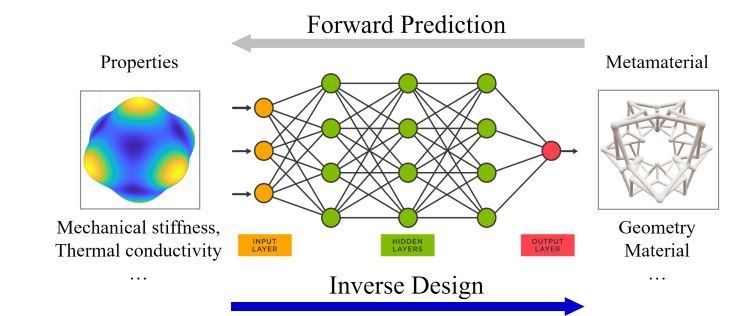

--------------

### Before you get started - Import library

Run the cell below to import necessarry python libraries for this tutorial.

In [1]:
# --- Standard library
import time
import math
import random

# --- Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load predefined functions
from homogenise2D import generate_BCC_unitcell
from MLPpackage import *

-----------

### 1. Parameterise BCC unit cell
- Use 4 Node Parameters to control the shape of a body-centred cubic (BCC) unit cell
- Create a binary matrix for a BCC unit cell, 1 to indicate the existence of materials.
- Use imshow(Matrix) to visualise.

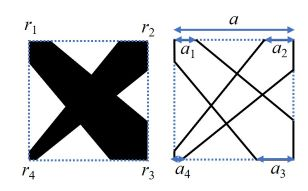

$$
r_1 = \frac{a_1}{a}, \quad
r_2 = \frac{a_2}{a}, \quad
r_3 = \frac{a_3}{a}, \quad
r_4 = \frac{a_4}{a}
$$


Use the function 'generate_BCC_unitcell' to create metamaterial unit cell

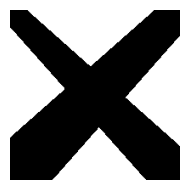

In [2]:
pattern = generate_BCC_unitcell(a=200, r1=0.1, r2=0.15, r3=0.20, r4=0.25)

### 2. Preprocess the dataset

**Load the prepared dataset**

The dataset contains 2D BCC metamaterial node parameters and their corresponding properties.
Each cell is controlled by four node parameters [r1, r2, r3, r4]. The recorded properties include the six independent components of the elasticity tensor [D11, D12, D13, D22, D23, D33], as well as the volume fraction [vf]. Therefore, the input dimension is 7 and output dimension is 4.

In [3]:
# --- Load the dataset as numpy array
data  = np.load("dataset_2D_BCC_500.npz")
prop  = data["prop"]    # input features
param = data["param"]   # target outputs

# --- Determine dimensions
N, in_dim  = prop.shape
_, out_dim = param.shape

# Print dataset information
print("=== Dataset Information ===")
print(f"Total samples (N): {N}")
print(f"Input  (prop):  shape = {prop.shape}, dtype = {prop.dtype}")
print(f"Output (param): shape = {param.shape}, dtype = {param.dtype}")
print(f"in_dim = {in_dim}, out_dim = {out_dim}")

=== Dataset Information ===
Total samples (N): 500
Input  (prop):  shape = (500, 7), dtype = float64
Output (param): shape = (500, 4), dtype = float64
in_dim = 7, out_dim = 4


**Split dataset to training, validation, testing dataset, with split ratios 0.7/0.15/0.15.**

We randomly shuffle the dataset and then split the dataset into training, validation, and test sets, so we can train, tune, and evaluate the model fairly. The training set is used to learn the model’s parameters, the validation set is used to choose hyperparameters and prevent overfitting (by checking how the model performs on unseen data during development), and the test set is kept completely separate until the very end to provide an unbiased estimate of how well the final model will generalise to new, real-world data.

In [4]:
prop_train, prop_val, prop_test, param_train, param_val, param_test = split_prop_param(
    prop, param, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, print_summary=True)

=== Dataset Split ===
Train: 349 samples
Val:   75 samples
Test:  76 samples


**Scale the dataset using min-max-scaling.**

We apply min-max scaling so that all features lie within the same numeric range, e.g. (-1,1) (0,1). This prevents features with large numeric values from dominating the learning process and makes gradient-based optimisation more stable and efficient. When inputs are on comparable scales, neural networks converge faster, are less sensitive to the initial weights, and can generalise better. Min-max scaling is also easy to interpret, since every scaled value directly reflects its relative position between the feature’s minimum and maximum in the training data.

In [5]:
prop_train, prop_val, prop_test, param_train, param_val, param_test, in_scaler, out_scaler = scale_datasets(
    prop_train, prop_val, prop_test, param_train, param_val, param_test,
    scale_inputs=True, scale_outputs=True, feature_range=(-1, 1), print_summary=True)

=== Scaling Info ===
Inputs scaled:  True
Outputs scaled: True
Feature range:  (-1, 1)


**Convert dataset numpy arrays to torch tensors.**

Because PyTorch’s whole training pipeline is built around tensors. Models, loss functions, and optimisers all expect tensor inputs, and only tensors support PyTorch’s automatic differentiation (needed for backpropagation and learning). Tensors can also be easily moved to GPU or other accelerators for faster training, while NumPy arrays stay on CPU. By using tensors, we get full integration with Dataset/DataLoader, efficient batch operations, and proper gradient computation during model training.

In [6]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = map(
    lambda a: torch.from_numpy(a).float(),
    (prop_train, param_train, prop_val, param_val, prop_test, param_test))

### 3. Define MLP model

In this block, we define a simple multilayer perceptron (MLP) that we’ll use as our model. 
- The MLP class builds a stack of fully connected layers based on the hidden sizes we pass in. Each layer followed by a ReLU activation and optional dropout for regularisation.
- HIDDEN=(8) for one hidden layer with 8 neurons, HIDDEN=(128,64) for two hidden layer with 128 and 64 neurons.  
- The activation function allows the network to learn non-linear relationship.
- Dropout randomly deactivates a fraction of neurons during training to reduce overfitting. 
- A final linear layer maps from the last hidden size to out_dim, giving us the desired output shape for our task. 

We also define a small helper function, count_params, to report how many trainable parameters the model has. 

Finally, we create an instance of the MLP with our chosen architecture and print both the model structure and its parameter count so we can see exactly what we’re working with.

In [7]:
# ——— Choose your hidden layers here ———
HIDDEN = (8,)         # e.g., (), (64,), (128,64), (256,128,64), ...
DROPOUT = 0.0          # use 0.0 for a baseline

# ——— Create the model ———
model = MLP(in_dim=in_dim, hidden=HIDDEN, out_dim=out_dim, dropout=DROPOUT)
# print(model) # uncomment this line if you'd like to see the MLP structure.
print(f"\nTrainable parameters: {count_params(model):,}")


Trainable parameters: 100


Draw a simple diagram of our MLP architecture, so we can visually inspect the structure of the network we’ve just defined.

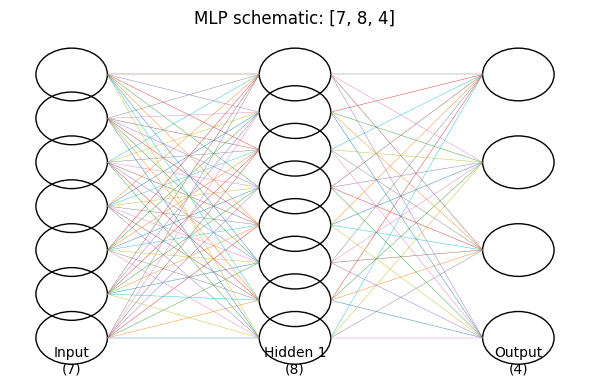

In [8]:
plot_mlp_schematic(in_dim, HIDDEN, out_dim)

### 4. Train MLP model

**Create DataLoaders: this block groups our data into manageable mini-batches for training, validation, and testing.**

We first wrap each split (X_*, Y_*) in a TensorDataset, which pairs inputs with their corresponding targets. We then create DataLoaders with a chosen BATCH_SIZE of 256, meaning the model will see 256 samples at a time before updating its parameters. The training loader also shuffles the data each epoch to improve learning, while the validation and test loaders keep the order fixed since we’re only evaluating performance there.

In [9]:
BATCH_SIZE = 256 # number of samples per mini-batch

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test),  batch_size=BATCH_SIZE, shuffle=False)

**Train the MLP model: this block trains the network over multiple epochs using mini-batches from the training DataLoader.**

For each batch, the model makes predictions, we compute the loss, backpropagate the gradients, and update the weights using the optimiser. The learning rate controls the step size of each gradient update, while the weight decay provides regularisation by discouraging overly large weights. At the end of each epoch, we switch to evaluation mode and compute the loss on the validation set to monitor how well the model is generalising. If the validation loss stops improving for several epochs, we trigger early stopping to avoid overfitting and wasting computation, typically keeping the best-performing model (with the lowest validation loss) as our final trained network.

In [10]:
model, train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    epochs=300, # training epoch
    patience=20, # early stopping if no validation improvement
    criterion=nn.MSELoss(), # Mean Squared Error (MSE) loss for regression
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4), # Adam optimizer – efficient and commonly used
)

=== Training started ===
Epoch   1/300 | Train: 0.310108 | Val: 0.303017
Epoch  20/300 | Train: 0.250623 | Val: 0.249555
Epoch  40/300 | Train: 0.186988 | Val: 0.190581
Epoch  60/300 | Train: 0.136896 | Val: 0.141000
Epoch  80/300 | Train: 0.099275 | Val: 0.101599
Epoch 100/300 | Train: 0.067495 | Val: 0.067842
Epoch 120/300 | Train: 0.041756 | Val: 0.041335
Epoch 140/300 | Train: 0.023984 | Val: 0.023488
Epoch 160/300 | Train: 0.014057 | Val: 0.013733
Epoch 180/300 | Train: 0.009035 | Val: 0.008670
Epoch 200/300 | Train: 0.006431 | Val: 0.006088
Epoch 220/300 | Train: 0.004967 | Val: 0.004680
Epoch 240/300 | Train: 0.004052 | Val: 0.003843
Epoch 260/300 | Train: 0.003464 | Val: 0.003287
Epoch 280/300 | Train: 0.003103 | Val: 0.002957
Epoch 300/300 | Train: 0.002828 | Val: 0.002680
=== Training complete ===


### 5. Visualise learning curves

**Plot learning curves: this block visualises how training and validation losses evolve, helping you see convergence and overfitting.**

If both training and validation losses stay high and don’t decrease much, the model is likely underfitting (too simple or not trained long enough). If the training loss keeps going down but the validation loss starts to level off or increase, the model is probably overfitting (memorising the training data instead of generalising). By inspecting these curves, you can decide whether to adjust the model size, regularisation, learning rate, or number of training epochs.

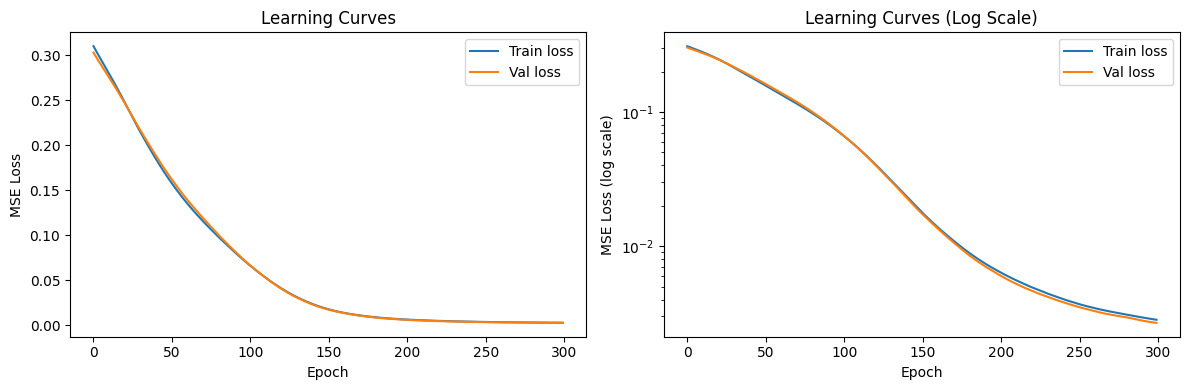

In [11]:
plot_learning_curves(train_losses, val_losses, metric_name="MSE Loss")

### 6. Test trained MLP model

Predict on the test set: this block uses the trained model to generate predictions for the unseen test data, then reverses any scaling so results are in the original physical units. 

It then computes common regression metrics (MAE, RMSE, and R²) for each output to quantify how accurately the model performs. 

It creates “parity plots” (true values vs. predicted values) for each output, which visually show how close the predictions are to the ideal diagonal line-making it easy to spot bias, scatter, or systematic errors.

In [12]:
y_true_plot, y_pred_plot, mae, rmse, r2 = evaluate_model(
    model,
    test_loader,
    out_dim=out_dim,
    out_scaler=out_scaler,
    scale_outputs=True, # if output is scaled in preprocessing, 'True' is to inverst scale, and compute y in original scale.
    print_summary=True,
)

=== Test Metrics per Output ===
Output 0: MAE=0.003674, RMSE=0.004507, R^2=0.9933
Output 1: MAE=0.004778, RMSE=0.005751, R^2=0.9898
Output 2: MAE=0.004112, RMSE=0.004930, R^2=0.9920
Output 3: MAE=0.004945, RMSE=0.005948, R^2=0.9891

Overall MAE:  0.004377
Overall RMSE: 0.005284
Mean R^2:     0.9910


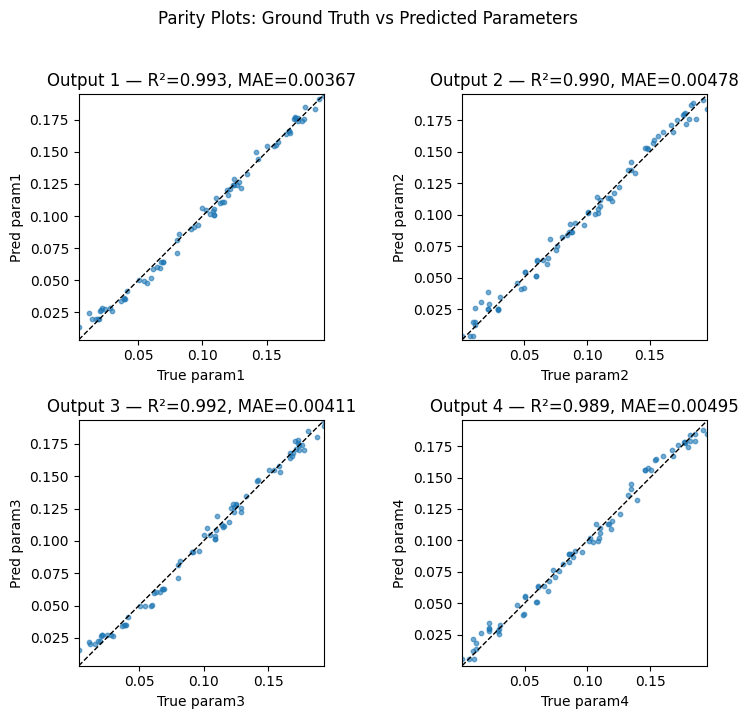

In [13]:
plot_parity_plots(
    y_true_plot=y_true_plot,
    y_pred_plot=y_pred_plot,
    mae=mae,
    r2=r2,
    out_dim=out_dim,
)